In [1]:
import sys
sys.path.append("../../")
from simulation_classes.drones import Drones
from simulation_classes.simulation_setting import SimulationSettings
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#### シミュレーターの設定(スケーリング含む)に必要な各種パラメータ
- 時間系
  - TOTAL_TIME: シミュレートする秒数
  - delta_t: 時間間隔
  - simulation_steps: 総ステップ数
- 距離のスケール
  - SCALING_FACTOR: [unit]を[m]に直すための係数。一旦これは定数で20にする。なので、simulation内で記述される速度 1 [unit/s]は20[m/s]に相当するということ。
- その他（運転系）
  - ドローン内に定義される変数ではあるが、max加速度とmin加速度は指定しても良いかもしれない。


In [32]:
TOTAL_TIME = 100
time_step = 0.1
simulation_steps = int(TOTAL_TIME / time_step)
scale_factor = 30
legal_speed = 1.5
real_legal_speed = max(2, legal_speed) * scale_factor * 3.6
print(f"この設定だと法定速度は時速{real_legal_speed}kmです")

この設定だと法定速度は時速216.0kmです



#### ドローンに関する設定の変数一覧
- 速度に関するもの
  - v_0: 初速度 (v_xの初期値として代入される)
  - legal_speed: 法定速度(その機体が出せる最高速度)
    - ※ そもそもOVモデルの最適速度関数内で、最大速度が2になっているので、legal_speedは2以上になっても結局2になる。なので、2以下で設定し、あとはscale_factorで調整するのが良いかも。
  - a: 感応度(最適速度に対してどのくらい近づこうとするかのパラメータ. 高いほど速度の収束が早い)
  - c: OVモデルに必要。おそらく車間距離に関するパラメタ

- その他、シミュレーション条件に相当するもの
  - xcor, ycor: 初期位置
  - volume（未実装）: 機体サイズ

In [41]:
DRONE_NUM = 20
v_0 = 0
a = 1
c = 2

drone_list = [Drones(i * (-1),0, 0,a,c,legal_speed) for i in range(DRONE_NUM)]

In [42]:
simulation = SimulationSettings(
    TOTAL_TIME=TOTAL_TIME, 
    time_step=time_step, 
    scale_factor=scale_factor,
    drone_list=drone_list
    )

In [43]:
simulation.run()

# print(simulation.drones[0].xcorList)

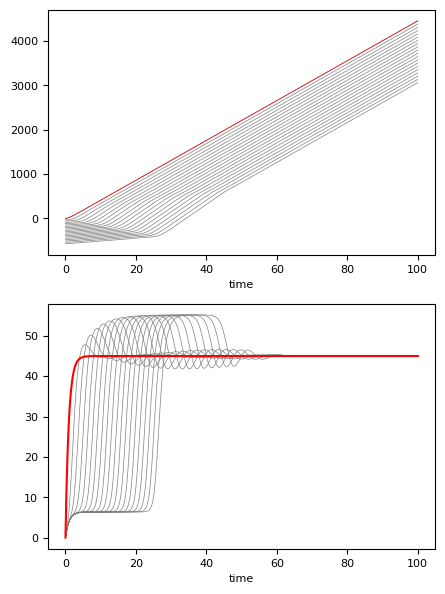

In [44]:
simulation.graph_show_scaled()

In [6]:
simulation.create_video()

### ここから下は動画を作るためのコード

・計算時間が結構長いのでそんなに頻繁に動かさない方が良いかも？

In [31]:
import cv2
import os

images = []
frames = simulation.simulation_steps
drones = simulation.drone_list

for i in range(frames):
    if (i%4 ==1):
        continue
    plt.figure(figsize=(4,2.4))
    for (droneNum, drone) in enumerate(drones):
        if (droneNum == 0):
            plt.scatter(drone.xcorList[int(i)], 0, color="red", s=6)
        else:
            plt.scatter(drone.xcorList[int(i)], 0, color="grey", s=6)
    plt.xlim(drones[-1].xcorList[0], drones[0].xcorList[-1] )
    plt.savefig(f"tmp/frame_{i}.png")
    plt.close()

    filename = 'tmp/frame_{}.png'.format(i)
    img = cv2.imread(filename)
    images.append(img)
    os.remove(f"tmp/frame_{i}.png")
    if (i%100 == 0):
        print(f"frame_{i}__Done")

print("動画作成開始")
output_file = 'tmp/output.mp4'
fps = 60
size = (images[0].shape[1], images[0].shape[0])

# 動画を保存するためのオブジェクトを生成する
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, fps, size)

# 100枚の画像を動画に書き込む
for i in range(len(images)):
    out.write(images[i])

# 動画を保存するための処理を終了する
out.release()
print("END")



frame_0__Done
frame_100__Done
frame_200__Done
frame_300__Done
frame_400__Done
frame_500__Done
動画作成開始


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


END


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(-10.0, 0, '−10'),
  Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70')])

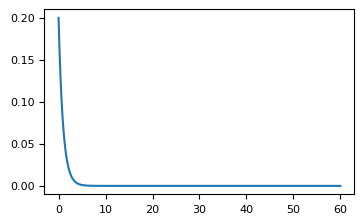

In [5]:
ax_list = np.diff(np.array(leader.v_xList))
t = np.linspace(0,time_step*(simulation_steps), simulation_steps)

plt.figure(figsize=(4,2.4))
plt.plot(t,ax_list)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)